Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

In [2]:
# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam


In [3]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Выходящий', 'Входящий']

In [4]:
# Определение
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['03450.jpg', '03533.jpg', '01900.jpg', '06152.jpg', '05255.jpg', '03163.jpg', '05421.jpg', '02336.jpg', '06146.jpg', '04596.jpg', '05850.jpg', '02884.jpg', '05975.jpg', '00118.jpg', '02337.jpg', '01905.jpg', '03346.jpg', '00462.jpg', '02773.jpg', '05755.jpg', '01290.jpg', '03959.jpg', '05842.jpg', '02999.jpg', '04540.jpg', '00349.jpg', '03132.jpg', '01848.jpg', '00510.jpg', '01991.jpg', '02156.jpg', '04900.jpg', '04474.jpg', '05644.jpg', '02729.jpg', '01561.jpg', '05012.jpg', '03082.jpg', '04189.jpg', '05330.jpg', '05278.jpg', '04545.jpg', '01994.jpg', '02839.jpg', '03518.jpg', '01595.jpg', '04875.jpg', '03102.jpg', '02228.jpg', '03667.jpg', '05127.jpg', '05315.jpg', '04131.jpg', '00235.jpg', '03767.jpg', '05100.jpg', '00982.jpg', '01804.jpg', '05266.jpg', '03619.jpg', '04404.jpg', '01870.jpg', '06208.jpg', '06174.jpg', '02836.jpg', '05541.jpg', '03703.jpg', '05926.jpg', '00416.jpg', '05008.jpg', '00880.jpg', '03117.jpg', '06358.jpg', '03097.jpg', '04623.jpg', '00171.jpg', 

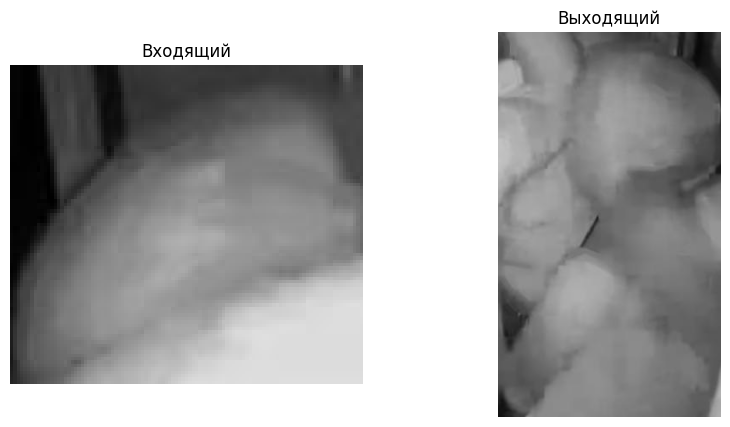

In [6]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [7]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [8]:
from tensorflow.keras.utils import to_categorical

target_size = (128, 128)

X = []

# Преобразуем все изображения в numpy-массив нужного размера
for path in data_files:
    img = image.load_img(path, target_size=target_size)              # Загружаем изображение
    img_array = image.img_to_array(img)                              # Переводим в массив numpy
    img_array = img_array / 255.0                                    # Нормализация значений
    X.append(img_array)                                              # Добавляем к общему списку

# Преобразуем список изображений в массив numpy
X = np.array(X)

# Преобразуем метки в numpy-массив
y = np.array(data_labels)

print(f"Форма массива X: {X.shape}")
print(f"Форма массива y: {y.shape}")

Форма массива X: (9081, 128, 128, 3)
Форма массива y: (9081,)


In [9]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [10]:
print(f'Размер обучающей выборки: {X_train.shape}, метки: {y_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}, метки: {y_test.shape}')

Размер обучающей выборки: (7264, 128, 128, 3), метки: (7264,)
Размер тестовой выборки: (1817, 128, 128, 3), метки: (1817,)


In [11]:
# Преобразуем метки в one-hot
y_train_hot = to_categorical(y_train, num_classes=CLASS_COUNT)
y_test_hot = to_categorical(y_test, num_classes=CLASS_COUNT)

# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*target_size, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(CLASS_COUNT, activation='softmax')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Разделение обучающей выборки на train и validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train_hot, test_size=0.2, random_state=42)

In [13]:
# Обучение модели
history = model.fit(
    X_train_final, y_train_final,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.7688 - loss: 0.8891 - val_accuracy: 0.7302 - val_loss: 0.5431
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9373 - loss: 0.1605 - val_accuracy: 0.5162 - val_loss: 1.2133
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9712 - loss: 0.0789 - val_accuracy: 0.9580 - val_loss: 0.1210
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9832 - loss: 0.0439 - val_accuracy: 0.9828 - val_loss: 0.0562
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9881 - loss: 0.0333 - val_accuracy: 0.9725 - val_loss: 0.0770
Epoch 6/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9884 - loss: 0.0340 - val_accuracy: 0.9814 - val_loss: 0.0514
Epoch 7/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9939 - loss: 0.0200 - val_accuracy: 0.9828 - val_loss: 0.0474
Epoch 8/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9955 - loss: 0.0163 - val_acc

In [14]:
from sklearn.metrics import f1_score

# Предсказания модели на тестовой выборке
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)         # Получаем метки предсказаний
y_true = np.argmax(y_test_hot, axis=1)           # Преобразуем one-hot в метки

# Расчёт f1-метрики с учётом дисбаланса
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Точность модели на тестовой выборке: {f1:.4f}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Точность модели на тестовой выборке: 0.9790


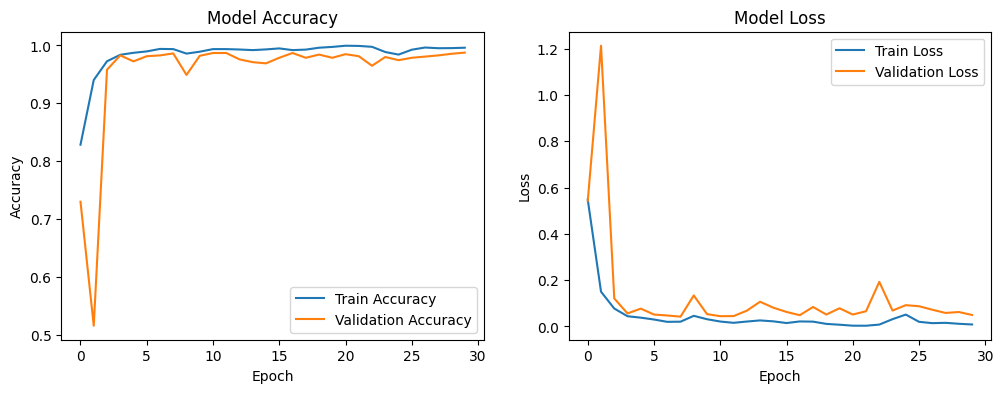

In [18]:
# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()